# Solving the HJB
The HJB equation, is used in dynamic programming to solve optimisation problem. Optimisation problems occur in all walks of life and some can even be solved. And some of those that can be solved are best solved with dynamic programming, a recursive evaluation of the best descission.

This notebook aims to explain by way of demonstration how to solve the HJB and fidn the optimal set of descissions, but also provide an easy to use base to formuate and solve your optimisation problems.

In [15]:
%matplotlib inline
import datetime
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import time
import scipy
from scipy import optimize, signal

import pandas as pd
from collections import Counter, defaultdict
from itertools import count

$$
v(s) = \min_x(cost(x,s) + v(new state(x,s)))
$$

In [84]:
class DynamicProgram(object):
    """
    Generate a dynamic program to find a set of optimal descissions using the HJB.
    
    define the program by:
    
    Setting intial states via:            set_inital_state(list or int)
    Setting the number of steps via:      set_step_number(int) 
    
    Add a set of descissions:             add_decisions_set(set)
    Add a cost function:                  add_cost_function(function in terms of state )
    
    Add a state change equation:          add_state_eq(function(state))
    Add an expression for the last value: add_final_value_expression(function(state,settings))
    Add limits on the states:             add_state_limits(lower=list or int,upper = list or int)

    See below for examples:
    
    """
    def __init__(self):
        self.settings = {
                        'Lower state limits' : [],
                        'Upper state limits' : [],    
                        'x_set' : set(),
                        'cache' : {},}
        
    def add_state_eq(self,function):
        """Returns a tuple describing the states. 
        Remember to increment the first state, b convention the number of steps.
        Load additional parameters (usually needed for cost and state value with global variables)
        
        Example of a function that changes the state by the decission:
        def new_state(x,s):
            return (s[0]+1,s[1]+x) #Return a tuple, use (s[:-1]+(5,)) to slice tuples.  
                
        """
        self.settings['State eq.'] = function
        
    def add_cost_function(self,function):
        """
        Returns a float or integer describing the cost value.
        Load additional parameters (usually needed for cost and state value with global variables)
        
        Example is a function that simply returns the decision as cost:
        def cost(x,s):
            return x
            
        """
        self.settings['Cost eq.'] = function
    
    def add_final_value_expression(self, function,):
        """
        Returns a float or integer as the final value:
        
        Example is a function that returns the ratio of the initial state and the final state:
        
        def val_T(s,settings):
            return s[1]/float(settings['Initial state'][1])
        """
        self.settings['Final value'] = function
        
        
    def set_step_number(self,step_number):
        """Number of stages / steps. Integer"""
        self.settings['T'] = step_number
        
    def set_inital_state(self,intial_values):
        """Provide the inital state of the states other than the stage number"""
        if type(intial_values) is list:
            self.settings['Initial state'] = intial_values
            self.settings['Initial state'].insert(0,0)
        elif type(intial_values) is int:
            self.settings['Initial state'] = [intial_values]
            self.settings['Initial state'].insert(0,0)
           
        self.settings['Initial state'] = tuple(self.settings['Initial state'])

        
    def add_state_limits(self,lower=[],upper=[]):
        """Add the limits on the state other than the stage number, leave empty if none"""
        if type(lower) is list:
            self.settings['Lower state limits'].extend(lower)
            self.settings['Upper state limits'].extend(upper)
        elif type(lower) is int:
            self.settings['Lower state limits'] = [lower]
            self.settings['Upper state limits'] = [upper]
        

        
    def solve(self):
        """
        Solves the HJB. Returns the optimal value.
        
        Path and further info is stored in the cache. Access it via 
        retrieve_decisions()
        """
        self.settings['cache'] ={}
        return self._hjb_(self.settings['Initial state'])
    
    def retrieve_decisions(self):
        """
        Retrieve the decisions that led to the optimal value
        
        Returns the cost for the different states, the optimal schedule and the states
        that the schedule results in.
        """
        sched = np.ones(self.settings['T'])*np.nan
        cost_calc= 0
        states = []

        s = self.settings['Initial state']
        t = 0

        while t < self.settings['T']:
            sched[t] = self.settings['cache'][s][1]

            cost_calc += self.settings['Cost eq.'](sched[t],s)
            states.append(s[1:])

            s = self.settings['State eq.'](sched[t],s)
            t += 1

        states.append(s[1:])

        return cost_calc, sched, states
    
    def return_settings(self):
        return self.settings
    
    def return_cache(self):
        return self.settings['cache']
        
    def add_decisions_set(self,set_of_decisions):
        """
        Add a set of permissable decissions. Must be set of unique integers.
        """
        if set(set_of_decisions) != set_of_decisions:
            raise TypeError('Expected a set unique values, use set() to declare a set')
        self.settings['x_set'] = set(set_of_decisions)
        
    def add_setting(self,key,value):
        self.settings[key] = value
       
    def _hjb_(self,s):
        if self.settings['cache'].has_key(s):
            return self.settings['cache'][s][0]

        # check state bounds
        for c,i in enumerate(s[1:]):
            if i < self.settings['Lower state limits'][c] or i > self.settings['Upper state limits'][c]:
                return float('inf')
            
        #Check if reached time step limit:
        if s[0] == self.settings['T']:            
            m = self.settings['Final value'](s,self.settings)
            self.settings['cache'][s] = [m, np.nan]
            return m

        # Else enter recursion
        else:
            ### Make decision variable vector ###
            ######################################################################################

                
            ### Slower but with any imutable decisions, uncomment if desired: ###
            p ={}
            for x in self.settings['x_set']:
                p[x] = self.settings['Cost eq.'](x,s)+self._hjb_(self.settings['State eq.'](x,s))
               
            pp = min(p, key=p.get)
            m = p[pp]
            ########################################################################################

            self.settings['cache'][s] = [m, pp]

            return m


We can also solve classic dynamic programming problems such as the knapsack problem, hannoi towers or the fibonacci number calculation. Blank functions are outlined below. 

The functions must fulfill a range of conditions:
$$
f:\mathcal{S}^n\times x \rightarrow  \mathbb{R}
$$
where $\mathcal{S}$ is the set of permissable states, $x$ the decision variable and $n$ the number of dimensions of the state. These are defined by $x \in \mathcal{X}$ the \texttt{set()} of permissable decisions. The state $s \in \mathcal{S}^n$ where $n \geq 2$ and $\mathcal{S} \subset \mathbb{R} $ and is finite. 

The new state is defined by a function such that: 
$$
f:\mathcal{S}^n\times x \rightarrow  \mathcal{S}^n
$$

The value of the final stage is defined as:
$$
f:\mathcal{S}^n \rightarrow  \mathbb{R}
$$
which as an impimentation detail has the required argument settings, to which features can be added through `add_setting(key,value)` where key must be a new and unique dictionary key and value may be any permissable dictionary entry.




In [70]:
#help(DynamicProgram)

In [71]:
def cost(x,s):
    """Return a float or integer"""
    pass

def new_state(x,s):
    """Return a tuple"""
    pass

def val_T(s,settings):
    """Return a float or int"""
    pass

We can solve a very simple pump optimsiation where the state of water in a tank is given by h and described by:
$$
s_{new} = \begin{cases} (t+1,h-1) & \text{if } x = 0  \\ (t+1,h+1) & \text{if } x = 1 \\ (t+1,h+1.5) & \text{if } x = 2\end{cases}
$$
The operating cost are described by:
$$
cost = tarrif(t)\times x
$$
where $x$ is the descission variable.
The final value is given by:
$$
V_T = \begin{cases} 0 & \text{if: } h_T \geq h_0 \\ Inf &\text{otherwise} \end{cases}
$$

    
    

In [86]:
def simple_cost(x,s):
    tariff = [19,  8,  20,  3, 12, 14,  0,  4,  3, 13, 11, 13, 13, 11, 16, 14, 16,
       19,  1,  8,  0,  4,   0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       12,  3, 18, 15,  3, 10, 12,  6,  3,  5, 11,  0, 11,  8, 10, 11,  5,
       15,  8,  2,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        9, 10, 13,  7,  7,  1, 12,  2,  2,  1,  5,  8,  4,  0, 11,  2,  5,
       16,  8,  1, 17, 16,  3,  0,  4, 16,  0,  7]
    return tariff[s[0]]*float(x[2])

def val_T(s,settings):
    if s[1] < settings['Initial state'][1]:
        return float('inf')
    else:
        return 0
    
def simple_state(x,s):
    #print s
    if x == 'x=1':
        return (s[0]+1,s[1]-1)
    elif x == 'x=2':
        return (s[0]+1,s[1]+1)
    elif x == 'x=6':
        return (s[0]+1,s[1]+1.5)

In [87]:
pumping = DynamicProgram()
pumping.set_step_number(6)
pumping.add_decisions_set({'x=1','x=2','x=6'})
pumping.add_cost_function(simple_cost)
pumping.add_state_eq(simple_state)
pumping.add_final_value_expression(val_T)
pumping.add_state_limits(lower=0,upper = 200)
pumping.set_inital_state(100)
# pumping.return_settings()


In [89]:
#%%timeit
pumping.settings['cache'] = {}
pumping.solve()
pumping.retrieve_decisions()

ValueError: could not convert string to float: x=1

We can have more than one state variable. For example we can add a second tank and now pump to either of them:
Here they have similar equations, but they can be completly independant, of each other. Any cost and state function that meets the requirments above is allowed.

$$
s_{new} = \begin{cases} (t+1,h_1-1,h_2-1) & \text{if } x = 0  \\ (t+1,h_1+1,h_2) & \text{if } x = 1 \\ (t+1,h_1,h_2+2) & \text{if } x = 2\end{cases}
$$

In [7]:
def simple_state2(x,s):
    if x == 0:
        return (s[0]+1,s[1]-1,s[2]-1)
    elif x == 1:
        return (s[0]+1,s[1]+1,s[2])
    elif x == 2:
        return (s[0]+1,s[1]  ,s[2]+2)

# We also need to update the final value function.
def val_T2(s,settings):
    if s[1] < settings['Initial state'][1] or s[2] < settings['Initial state'][2]:
        return float('inf') 
    else:
        return 0
    
# For now we leave the cost function the same, but that could also be changed.

One final example is the checkerboard problem as outlined here: https://en.wikipedia.org/wiki/Dynamic_programming#Checkerboard

In [8]:
board = np.array([[1,3,4,6],
                  [2,6,2,1],
                  [7,3,2,1],
                  [0,4,2,9]])

def cost(x,s):
    """Return a float or integer"""
    global board
    return board[s[0],s[1]]
    

def new_state(x,s):
    """Return a tuple"""
    global board
    return (int(s[0]+1),int(s[1]+x)) 

def val_T(s,settings):
    """Return a float or int"""
    global board
    return board[s[0],s[1]]

Checkerboard = DynamicProgram()
Checkerboard.add_cost_function(cost)
Checkerboard.add_decisions_set({-1,0,1})
Checkerboard.add_final_value_expression(val_T)
Checkerboard.add_state_eq(new_state)
Checkerboard.add_state_limits(lower=-1,upper=3)
Checkerboard.set_inital_state(2)
Checkerboard.set_step_number(3)
Checkerboard.solve()
print Checkerboard.retrieve_decisions()

(6, array([ 1.,  0., -1.]), [(2,), (3,), (3,), (2,)])


In [9]:
%%timeit
Checkerboard.solve()


10000 loops, best of 3: 134 µs per loop


An example we can solve is the water allocation problem from the tutorial sheets:

Consider a water supply allocation problem. Suppose that a quantity Q can be
allocated to three water users (indices j=1, 2 and 3), what is allocation x4 which
maximises the total net benefits?
The gross benefit resulting from the allocation of $x_j$ to j is:

$$
a_j(1-exp(-b_jx_j)) 
$$
Subject to $ (a_j, b_j > 0). $
Moreover, the costs of this allocation are:

$c_jx_j^{d_j}$ ($c_j$, $d_j >0$ and $d_j<1$, because of economy of scale).



The values of the constants are:
Q=5

|   | $a_j$|$b_j$|$c_j$|$d_j$|
|---|---|---|---|---|
|j=1 |100|0.1| 10|0.6|
|j=2 | 50|0.4| 10|0.8|
|j=3 |100|0.2| 25|0.4|

Solve the problem in the discrete case (i.e. assuming that $x_j$ is an integer).

The optimisation problem is therefore:
$$
Maximise  \sum_j (a_j(1-exp(-b_jx_j)) - c_jx_j^{d_j}
$$
$$
subject to: \sum_j x_j \leq Q
$$
$$
x_j \geq 0
$$

This problem is a non-linear mixed integer problem and quite expensive to solve as branch and bound problem. But with DP it is much easier. (The continous case, may be much easier as NLP than DP, this shows how important it is to pay attenttion ot the problem type)

The decisions are 0 ... 5
The states are the amount of water allocated.

In [10]:
Costs = np.array([[100,0.1, 10,0.6],
                              [50, 0.4, 10,0.8],
                              [100,0.2, 25,0.4]])

def value(x,s):
    global Costs
    return Costs[s[0],0]*(1-math.exp(-Costs[s[0],1]*x))
    

def cost(x,s):
    """Return a float or integer"""
    global Costs
    return   -value(x,s) +Costs[s[0],2]*x**Costs[s[0],3]
    

def new_state(x,s):
    """Return a tuple"""
    return s[1]-x
    
    
def val_T(s,settings):
    """Return a float or int"""
    pass

## Stochastic Programming

$$
v(s,i) = \min_x( cost(x,s,i)+\sum_j (p_{i,j} \times v(newstate(x,s,j))) )
$$

Where the probability $p_{i,j}$ is the probaility of jumping from state $i$ to state $j$. Currently the transition matrix is invariate, however this can be easily implimented with P as a list of lists.


In [11]:
class StochasticProgram(DynamicProgram):
    """
    Adds a stochastic component to the dynamic program.
    
    state now is: s where s[0] is the step s[1:-1] is the states of the system and s[-1] is the stochastic state
    
    The transition matrix for the markov chain describing the stochastic bhavior is added by:
    add_transition_matrix(P) with P as a list of lists.
    
    
    """
    def add_transition_matrix(self,P):
        """
        Add the transition matrix as list of lists
        
        eg. P = [[0.4,0.5,0.1],
                 [0.2,0.6,0.2],
                 [0.1,0.5,0.4]]
        
        """
        self.settings['P'] = np.array(P)
        self.settings['Len P'] = len(P)
        
    def retrieve_decisions(self):
        """
        Retrieve the decisions that led to the optimal value
        
        Returns the cost for the different states, the optimal schedule and the states that the schedule results in.
        """
        schedule = []
        cost_calc= np.zeros(self.settings['Len P'])
        states = []
        
        #Initial decission from intial state
             
        
        for i in range(self.settings['Len P']):
            s = self.settings['Initial state']
            states_part = [s, ]
            schedule_part = []#self.settings['cache'][s][1], ] # first decission 
            
            for t in range(0,self.settings['T']):
                schedule_part.append(self.settings['cache'][s][1])
                
                cost_calc[i] += self.settings['Cost eq.'](schedule_part[t],s)
                s = self.settings['State eq.'](schedule_part[t],(s[:-1]+(i,)))
                states_part.append(s)
                #schedule_part.append(self.settings['cache'][s][1])
                
                
            
            states.append(states_part)
            schedule.append(schedule_part)

        return cost_calc, schedule, states

    def print_pump_decisions(self):
        """Make a pretty print out of the pumping decisions"""
        cost_calc, schedule, states = self.retrieve_decisions()
        print "Wind states:", range(self.settings['Len P'])
        print "Computed cost: ", cost_calc
        #print states
        #print schedule
        
        
        for t in range(self.settings['T']): 
            
            print 'Time step: '+ str(t)
            print '      State: ',
            for i in range(self.settings['Len P']):
                print states[i][t],#, states
            print "\r"
            
            print '      Decision: ',
            for i in range(self.settings['Len P']):  
                print schedule[i][t],#, states
            print "\r"
            
        print 'Final State: ',
        for i in range(self.settings['Len P']):
            
            print states[i][-1],
            
        
    

    def solve(self):
        """
        Solves the HJB. Returns the optimal value.
        
        Path and further info is stored in the cache. Access it via 
        retrieve_decisions()
        """
        self.settings['cache'] = {}
        return self._hjb_stoch_(self.settings['Initial state'])
    
    
    
    
    def _hjb_stoch_(self,s):
        if self.settings['cache'].has_key(s):
            return self.settings['cache'][s][0]

        # check state bounds
        for c,i in enumerate(s[1:-1]):
            if i < self.settings['Lower state limits'][c] or i > self.settings['Upper state limits'][c]:
                return 999999999999999999.0 # inf*0 is nan not 0 :(
            
        #Check if reached time step limit:
        if s[0] == self.settings['T']:            
            m = self.settings['Final value'](s,self.settings)
            self.settings['cache'][s] = [m, np.nan]
            return m

        # Else enter recursion
        else:
            
            # Move to local variables for speed
            x_set = self.settings['x_set']
            _hjb_stoch_ = self._hjb_stoch_
            state_eq =  self.settings['State eq.']
            P = self.settings['P']
            cost = self.settings['Cost eq.']
            
            # Loop
            p =[]
            #p = np.empty([len(self.settings['x_set']), 1])
            for x in x_set:
                #for i in range(len(P)):
                    #print _hjb_stoch_(state_eq(x,(s[0:-1]+ (i,)))),P[s[-1],i]
                
                
                future = sum(_hjb_stoch_(state_eq(x,(s[0:-1]+ (i,))))*P[s[-1],i]  for i in range(len(P)) if P[s[-1],i] > 0 )
            
                p.append(cost(x,s) + future)
                #p[x] = cost(x,s) + future
        
            #m = min(p, key=p.get)
            #print p, len(p)
            m = min(p)

            for x in x_set:
                if m == p[x]:
                    pp = x

            
            self.settings['cache'][s] = [m, pp]

            return m
     
    
    

The cost of operating a pump with a given wind turbine power input given by a certain state is given by:
$$
cost(x,t,h,j) := \begin{cases} T(t) \times (x \times P_p - W(t,j)) & \text{if} +ve \\ 
E_{xp} \times (x \times P_p - W(t,j)) & \text{if} -ve\end{cases}
$$
where $W(t,j)$ is the wind power output at time $t$ with an error state $j$.

In [12]:
# Convention s = t,h,j
def stoch_simple_state(x,s):
    #print s
    if x == 0:
        return (s[0]+1,s[1]-1,s[2])
    elif x == 1:
        return (s[0]+1,s[1]+1,s[2])
    elif x == 2:        
        return (s[0]+1,s[1]+1.5,s[2])
    

def err_corr_wind_power_cost(x,s):
    Tariff = [5,5,5,5,5,8,8,8,8,8,12,12,12,12,12,50,50,50,50,20,20,6,5,5]
    Wind = [46,  1,  3, 36, 30, 19,  9, 26, 35,  5, 49,  3,  6, 36, 43, 36, 14,
       34,  2,  0,  0, 30, 13, 36]
    
    diff = np.array([-1,0,1])*3
    
    Export_price = 5.5
    
    wind_out = Wind[s[0]]+diff[s[2]]
    if wind_out <= 0:
        wind_out = 0
    
    power_con = x*60-wind_out
    if power_con >= 0:
        return power_con*Tariff[s[0]]
    else:
        return power_con*Export_price
    
def different_wind_cost(x,s):
    Tariff = [5,5,5,5,5,8,8,8,8,8,12,12,12,12,12,50,50,50,50,20,20,6,5,5]
    Wind = [[46,1,3,36,30,19,9,26,35,5,49,3,6,36,43,36,14,34,2,0,0,30,13,36],
            [4,49,3,6,36,43,6,14,1,3,36,30,19,9,26,35,5,34,2,0,0,30,13, 36],
            [3,6,30,43,36,14,34,46,1,3,6,3,9,9,2,35,5,49,2,19,10,30,13,36]]
    
    
    Export_price = 5.5
    
    wind_out = Wind[s[2]][s[0]]
       
    power_con = x*60-wind_out
    if power_con >= 0:
        return power_con*Tariff[s[0]]
    else:
        return power_con*Export_price

def val_T(s,settings):
    if s[1] < settings['Initial state'][1]:
        return 999999999999999999.0
    else:
        return 0

    
transition = np.array([[0.5,0.5,0.0],[0.2,0.6,0.2],[0.1,0.5,0.4]])

pumping_stoch = StochasticProgram()
pumping_stoch.add_decisions_set({0,1,2})
#pumping_stoch.add_cost_function(err_corr_wind_power_cost)
pumping_stoch.add_cost_function(different_wind_cost)
pumping_stoch.add_state_eq(stoch_simple_state)
pumping_stoch.add_final_value_expression(val_T)
pumping_stoch.add_state_limits(lower=[0,0],upper = [200,3])
pumping_stoch.set_inital_state([100,1])
pumping_stoch.set_step_number(3)
pumping_stoch.add_transition_matrix(transition)
#print pumping_stoch.settings
pumping_stoch.solve()
pumping_stoch.print_pump_decisions()

Wind states: [0, 1, 2]
Computed cost:  [ 558.5  295.5  385. ]
Time step: 0
      State:  (0, 100, 1) (0, 100, 1) (0, 100, 1) 
      Decision:  1 1 1 
Time step: 1
      State:  (1, 101, 0) (1, 101, 1) (1, 101, 2) 
      Decision:  1 0 1 
Time step: 2
      State:  (2, 102, 0) (2, 100, 1) (2, 102, 2) 
      Decision:  0 1 0 
Final State:  (3, 101, 0) (3, 101, 1) (3, 101, 2)


# Wind turbine operation and scheduling

We pick a wind turbine, pumps and network layout.



In [2]:
def Turb_power(s,Cutin=4,Rated=15,Cutoff=25,TurbName = "V90/3MW"):
    """Describes the power output of a wind turbine as function of windspeed
    Cutin is the lower wind speed limit, Cutoff is the upper windspeed limit 
    and Limit is the point at which the power no longer increases as the 
    nominal power has been reached.
    
    Example Vestas V90
    Cut In:  4 m/s
    Rated:   15 m/s
    Cut Out: 25 m/s
    
    for partial range of V90/3MW we use to 6th order polynomial fitted to the curve
    """
    if TurbName == "V90/3MW":
        if s < Cutin:
            return 0
        elif s < 11:
            x = np.arange(4,12)
            y = np.array([75, 187, 348, 574, 875, 1257, 1688, 2118])
            p = np.polyfit(x, y, 6)
            return np.polyval(p,s)
        elif s < 17:
            x = np.arange(11,18)
            y = np.array([2118, 2514, 2817, 2958, 2994, 2999, 3000])
            p = np.polyfit(x, y, 6)
            return np.polyval(p,s)
        elif s < Cutoff:
            return 3000
        else:
            return 0
    else:
        factor = Turb_factor(Power,rating)
        if s < Cutin:
            return 0
        elif s < Rated:
            return (s**3)*factor
        elif s < Cutoff:
            return Rated**3*factor
        else:
            return 0

def Turb_factor(Power,rating):
    """Given a Rated power and rating speed, computes the conversion factor"""
    return float(Power)/rating**3


def tmatrix(lst,J_max=None):
    """from http://stackoverflow.com/questions/28013878/calculate-transition-matrix-of-letters?lq=1
    defaultdict that'll produce a unique index for each unique character
    encountered in lst
    """
    indices = defaultdict(count().next)
    print len(set(lst))
    if J_max is None:
        print len(set(lst))
        print set(lst)
        J_max = len(set(lst))
      
    b = np.zeros([J_max,J_max])
    
    Ct = Counter(zip(lst, lst[1:])) # zip together consecutive elements of the list

    for (x, y), c in iter(sorted(Ct.iteritems())): # make sorted iteration to generate sorted trasition matrix
        b[x,y] = float(c)
        #b[indices[x],indices[y]] = float(c)
       
    res = dict((v,k) for k,v in indices.iteritems())
    
    b = np.array(b)
    
    # Normalise 
    for i in range(len(b)):
        div = float(b.sum(axis=1)[i])
        if div > 0:
            b[i] = b[i]/div
        
    return b, indices

def make_Forecast(wind,order=2,digital_pass=0.1):
    """Low pass filter to generate wind forecast"""
    # Low Pass
    b, a = scipy.signal.butter(order,digital_pass, 'low') #4, 100, 'low'
    return scipy.signal.filtfilt(b, a,wind )

def digitize_wind(x,J_max,uniform=False,centered=True):
    
    if uniform:
        x_sorted = np.array(sorted(x))
        bin_edge = np.linspace(0,len(x),num=J_max, endpoint=False, dtype=int)
        bins = x_sorted[bin_edge]
    else:
        if centered:
            bins = np.linspace(-max(abs(x)),max(abs(x))+0.00001,J_max+1) # last bin is empty
        else:
            bins = np.linspace(min(x),max(x),J_max)
    
    #print bins
    bins_states = np.append(bins,max(x))
    
    bin_means = []
    for i in range(J_max):
        bin_means.append((bins_states[i]+bins_states[i+1])/2)

    return np.digitize(x,bins)-1, np.array(bin_means)


def plot_T_mat(T_mat,save=False,name=None):
    plt.figure(figsize=(5,5),tight_layout=True)
    plt.pcolor(T_mat)
    plt.set_cmap('gray_r')
    plt.colorbar()
    plt.axis([0,len(T_mat),0,len(T_mat)])
    ax=plt.gca()                            # get the axis
    ax.set_ylim(ax.get_ylim()[::-1])
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    plt.xlabel('Error State')
    plt.ylabel('Error State')
    
    if save == True and name is not None:
        #print pwd+name
        plt.savefig( "D:\Phd\DP\ " + name + ".pdf" ,  format='pdf')
    elif save == True:
        raise ValueError("Please provide a name for figure")
    
    plt.show()

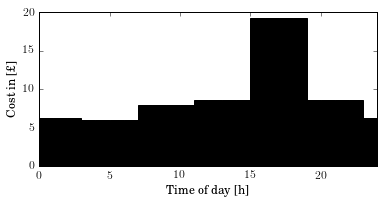

In [148]:
# Electricity tariff
idx = pd.date_range('1/1/2011', periods=25, freq='H')
tariff = pd.Series([6.2000,6.2000,6.2000,6.0000,6.0000,6.0000,6.0000,7.9000,7.9000,7.9000,7.9000,8.5000,
                    8.5000,8.5000,8.5000,19.200,19.200,19.200,19.200,8.5000,8.5000,8.5000,8.5000,6.2000,6.2],
                   index=idx)

Tariff = tariff.resample('60T').ffill().tolist()[:-1]

plt.figure(figsize=(5.5,3))
plt.bar(range(len(Tariff)),Tariff,width=1,color='black')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
plt.xlabel(r'Time of day [h]')
plt.ylabel(r'Cost in [\pounds]')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,24,y1,y2))
plt.tight_layout()
plt.savefig('tariff.pdf')
plt.show()


In [149]:
# selected pump
# http://product-selection.grundfos.com/product-detail.catalogue.product%20families.hs.html?from_suid=14781123059720296662871712975&pumpsystemid=159855735&qcid=159855770 

In [14]:
T_mat_11, b = tmatrix(df['Digital Pwr Error state 11'],11)
#print T_mat_11
print T_mat

NameError: name 'df' is not defined

In [75]:
df['Digital Pwr Error state 5']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),5)
df['Digital Pwr Error 5 [kW]'] = df['Digital Pwr Error state 5'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 5'] = df['Digital Pwr Error state 5'].abs() - df['Forecast error'].abs()
df['Digitalisation error 5']abs().mean() 

-66.13157778624561

In [3]:
df  = pd.read_csv('Santa_clara_data.txt',parse_dates={'datetime':[1,0]})
df['datetime'] = df['datetime'].map(lambda x: x.replace('24:','00:'))
df['datetime']=pd.to_datetime(df['datetime'], format='%H:%M %m/%d/%Y' )
df = df.set_index('datetime')
df = df[df['Avg Wind Speed @ 140ft [m/s]'] != -99999]
df.index.freq = 'T'
df['Power'] = df['Avg Wind Speed @ 140ft [m/s]'].map(lambda x: Turb_power(x,TurbName ="V90/3MW"))
df['Forecasted power'] = make_Forecast(df['Power'],digital_pass=0.1)
df['Forecast error'] = df['Power']-df['Forecasted power'] 

In [10]:
df['Forecast error'].std()

119.54928875538496

In [64]:
df['Digital Pwr Error state 5']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),5)
df['Digital Pwr Error 5 [kW]'] = df['Digital Pwr Error state 5'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 5'] = df['Digital Pwr Error state 5'].abs() - df['Forecast error'].abs()

df['Digital Pwr Error state 7']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),7)
df['Digital Pwr Error 7 [kW]'] = df['Digital Pwr Error state 7'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 7'] = df['Digital Pwr Error state 7'].abs() - df['Forecast error'].abs()

df['Digital Pwr Error state 9']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),9)
df['Digital Pwr Error 9 [kW]'] = df['Digital Pwr Error state 9'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 9'] = df['Digital Pwr Error state 9'].abs() - df['Forecast error'].abs()

df['Digital Pwr Error state 11']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),11)
df['Digital Pwr Error 11 [kW]'] = df['Digital Pwr Error state 11'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 11'] = df['Digital Pwr Error state 11'].abs() - df['Forecast error'].abs()

df['Digital Pwr Error state 21']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),21)
df['Digital Pwr Error 21 [kW]'] = df['Digital Pwr Error state 21'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 21'] = df['Digital Pwr Error state 21'].abs() - df['Forecast error'].abs()

df['Digital Pwr Error state 31']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),31)
df['Digital Pwr Error 31 [kW]'] = df['Digital Pwr Error state 31'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 31'] = df['Digital Pwr Error state 31'].abs() - df['Forecast error'].abs()

df['Digital Pwr Error state 51']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),51)
df['Digital Pwr Error 51 [kW]'] = df['Digital Pwr Error state 51'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 51'] = df['Digital Pwr Error state 51'].abs() - df['Forecast error'].abs()

df['Digital Pwr Error state 101']  , digital_error_states = digitize_wind(np.array(df['Forecast error'].tolist()),101)
df['Digital Pwr Error 101 [kW]'] = df['Digital Pwr Error state 101'].map(lambda x: digital_error_states[x] )
df['Digitalisation error 101'] = df['Digital Pwr Error state 101'].abs() - df['Forecast error'].abs()

In [65]:
df15 = df.resample('15T').mean()
df20 = df.resample('20T').mean()
df30 = df.resample('30T').mean()
df60 = df.resample('60T').mean()

In [76]:
print df['Digitalisation error 5'].abs().mean()
print df['Digitalisation error 7'].abs().mean()
print df['Digitalisation error 9'].abs().mean()
print df['Digitalisation error 11'].abs().mean()
print df['Digitalisation error 21'].abs().mean()
print df['Digitalisation error 31'].abs().mean()
print df['Digitalisation error 51'].abs().mean()
print df['Digitalisation error 101'].abs().mean()

66.6190772132
65.9644453019
65.3569009058
64.7920743324
62.446349776
60.6937388468
58.5124795419
59.1556749215


Help on class Counter in module collections:

class Counter(__builtin__.dict)
 |  Dict subclass for counting hashable items.  Sometimes called a bag
 |  or multiset.  Elements are stored as dictionary keys and their counts
 |  are stored as dictionary values.
 |  
 |  >>> c = Counter('abcdeabcdabcaba')  # count elements from a string
 |  
 |  >>> c.most_common(3)                # three most common elements
 |  [('a', 5), ('b', 4), ('c', 3)]
 |  >>> sorted(c)                       # list all unique elements
 |  ['a', 'b', 'c', 'd', 'e']
 |  >>> ''.join(sorted(c.elements()))   # list elements with repetitions
 |  'aaaaabbbbcccdde'
 |  >>> sum(c.values())                 # total of all counts
 |  15
 |  
 |  >>> c['a']                          # count of letter 'a'
 |  5
 |  >>> for elem in 'shazam':           # update counts from an iterable
 |  ...     c[elem] += 1                # by adding 1 to each element's count
 |  >>> c['a']                          # now there are seven 'a'
 |  

5


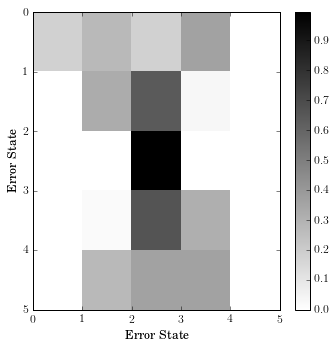

7


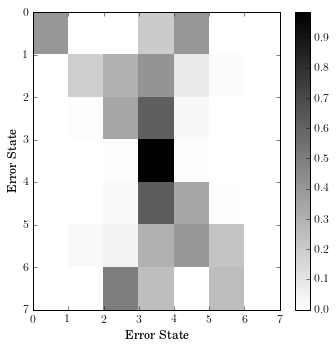

9


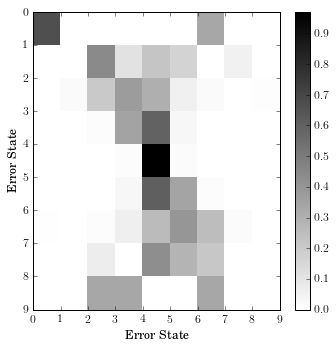

11


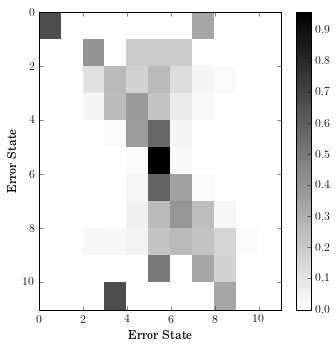

21


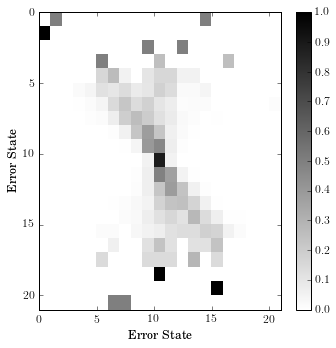

27


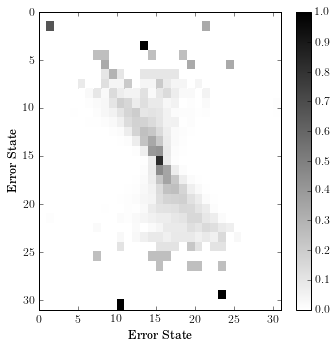

41


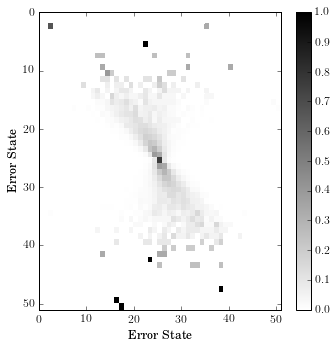

73


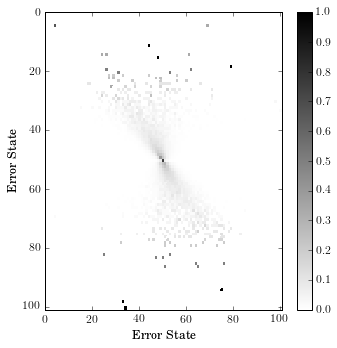

In [132]:
T_mat_5, b = tmatrix(df['Digital Pwr Error state 5'],5)
plot_T_mat(T_mat_5,save=True,name='J5_t_mat_new')

T_mat_7, b = tmatrix(df['Digital Pwr Error state 7'],7)
plot_T_mat(T_mat_7,save=True,name='J7_t_mat_new')

T_mat_9, b = tmatrix(df['Digital Pwr Error state 9'],9)
plot_T_mat(T_mat_9,save=True,name='J11_t_mat_new')

T_mat_11, b = tmatrix(df['Digital Pwr Error state 11'],11)
plot_T_mat(T_mat_11,save=True,name='J11_t_mat_new')

T_mat_21, b = tmatrix(df['Digital Pwr Error state 21'],21)
plot_T_mat(T_mat_21,save=True,name='J21_t_mat_new')

T_mat_31, b = tmatrix(df['Digital Pwr Error state 31'],31)
plot_T_mat(T_mat_31,save=True,name='J31_t_mat_new')

T_mat_51, b = tmatrix(df['Digital Pwr Error state 51'],51)
plot_T_mat(T_mat_51,save=True,name='J51_t_mat_new')

T_mat_101, b = tmatrix(df['Digital Pwr Error state 101'],101)
plot_T_mat(T_mat_101,save=True,name='J101_t_mat_new')

4
(0, 1) 1
(1, 1) 1
(1, 2) 2
(1, 4) 3
(2, 1) 1
(2, 2) 5
(2, 4) 1
(4, 1) 3


(array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.16666667,  0.33333333,  0.        ,  0.5       ],
        [ 0.        ,  0.14285714,  0.71428571,  0.        ,  0.14285714],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ]]),
 defaultdict(<method-wrapper 'next' of itertools.count object at 0x0000000016640FC8>,
             {}))

In [36]:
print "10 mins ", df['Power'].std()
print "15 mins ", df15['Power'].std()
print "20 mins ", df20['Power'].std()
print "30 mins ", df30['Power'].std()
print "60 mins ", df60['Power'].std()

10 mins  738.951814157
15 mins  736.154208725
20 mins  734.392927389
30 mins  731.620609895
60 mins  725.486909754


Avg Wind Speed @ 140ft [m/s]        Power  \
datetime                                                         
2000-01-01 00:00:00                        11.650  1847.319578   
2000-01-01 00:15:00                         6.774   515.891312   
2000-01-01 00:30:00                         7.645   764.181485   
2000-01-01 00:45:00                         8.060   896.687275   
2000-01-01 01:00:00                         8.695  1134.544592   
2000-01-01 01:15:00                         8.710  1139.118057   
2000-01-01 01:30:00                         8.395  1017.862910   
2000-01-01 01:45:00                         8.520  1065.114438   
2000-01-01 02:00:00                         8.335   999.148693   
2000-01-01 02:15:00                         9.090  1293.821494   
2000-01-01 02:30:00                         9.135  1312.794922   
2000-01-01 02:45:00                         9.040  1273.007437   
2000-01-01 03:00:00                         9.755  1580.795616   
2000-01-01 03:15:00                        10.520  1916.170892   
2000-01-01 03:30:00                        10.235  1791.777485   
2000-01-01 03:45:00                         9.710  1560.372812   
2000-01-01 04:00:00                         9.560  1495.645139   
2000-01-01 04:15:00                         9.110  1302.182236   
2000-01-01 04:30:00                         8.825  1186.311051   
2000-01-01 04:45:00                         9.970  1674.936332   
2000-01-01 05:00:00                        10.710  1997.218778   
2000-01-01 05:15:00                        10.890  2072.911039   
2000-01-01 05:30:00                        10.040  1705.820678   
2000-01-01 05:45:00                        10.300  1820.342177   
2000-01-01 06:00:00                        10.495  1901.391293   
2000-01-01 06:15:00                         8.620  1103.762083   
2000-01-01 06:30:00                         8.800  1196.448414   
2000-01-01 06:45:00                         9.980  1679.351999   
2000-01-01 07:00:00                        10.595  1932.047485   
2000-01-01 07:15:00                        10.790  2031.261768   
...                                           ...          ...   
2005-06-09 14:45:00                        10.820  2043.820008   
2005-06-09 15:00:00                        10.520  1915.987052   
2005-06-09 15:15:00                        10.650  1972.010312   
2005-06-09 15:30:00                        11.135  2168.858984   
2005-06-09 15:45:00                        11.060  2139.892911   
2005-06-09 16:00:00                        10.655  1974.138084   
2005-06-09 16:15:00                        10.720  2001.762884   
2005-06-09 16:30:00                        10.695  1990.834893   
2005-06-09 16:45:00                        10.960  2101.684542   
2005-06-09 17:00:00                        10.385  1857.487506   
2005-06-09 17:15:00                        11.240  2209.161002   
2005-06-09 17:30:00                        11.840  2451.738641   
2005-06-09 17:45:00                        11.460  2298.110016   
2005-06-09 18:00:00                        11.815  2431.720230   
2005-06-09 18:15:00                        11.500  2314.487305   
2005-06-09 18:30:00                        11.290  2229.427298   
2005-06-09 18:45:00                        11.600  2355.417984   
2005-06-09 19:00:00                        11.755  2416.733468   
2005-06-09 19:15:00                        12.100  2551.239475   
2005-06-09 19:30:00                        11.540  2330.612505   
2005-06-09 19:45:00                        11.680  2387.989830   
2005-06-09 20:00:00                        11.860  2459.674189   
2005-06-09 20:15:00                        11.640  2371.733804   
2005-06-09 20:30:00                        11.560  2338.843688   
2005-06-09 20:45:00                        11.300  2233.111879   
2005-06-09 21:00:00                        10.920  2085.279610   
2005-06-09 21:15:00                        11.100  2154.866009   
2005-06-09 21:30:00                        10.360  1846.10654

In [ ]:
wind_10  = wind_10 [wind_10 ['Avg Wind Speed @ 140ft [m/s]'] != -99999]
wind_10.rename(columns={'PST_DATE (MM/DD/YYYY)': 'Time','Avg Wind Speed @ 140ft [m/s]': 'Wind'}, inplace=True)
df['Avg Wind 20mins'] = df['Wind'].rolling(window=2,center=False).mean()
wind_20 = df.iloc[1::2]
df['Avg Wind 30mins'] = df['Wind'].rolling(window=3,center=False).mean()
wind_30 = df.iloc[2::3]
df['Avg Wind 60mins'] = df['Wind'].rolling(window=6,center=False).mean()
wind_60 = df.iloc[5::6]


In [64]:
wind_10['Power'] = wind_10['Wind']
wind_10['Power'] = wind_10['Power'].apply(lambda x: Turb_power(x,TurbName ="V90/3MW"))

wind_20['Power'] = wind_20['Avg Wind 20mins']
wind_20['Power'] = wind_20['Power'].apply(lambda x: Turb_power(x,TurbName ="V90/3MW"))

wind_30['Power'] = wind_30['Avg Wind 30mins']
wind_30['Power'] = wind_30['Power'].apply(lambda x: Turb_power(x,TurbName ="V90/3MW"))

wind_60['Power'] = wind_60['Avg Wind 60mins']
wind_60['Power'] = wind_60['Power'].apply(lambda x: Turb_power(x,TurbName ="V90/3MW"))

C:\Users\rmm08\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rmm08\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rmm08\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [80]:
wind

Avg Wind Speed @ 140ft [m/s]
datetime                                     
00:10 1/1/2000                          7.440
00:20 1/1/2000                          6.774
00:30 1/1/2000                          7.290
00:40 1/1/2000                          8.000
00:50 1/1/2000                          8.060
01:00 1/1/2000                          8.900
01:10 1/1/2000                          8.490
01:20 1/1/2000                          8.710
01:30 1/1/2000                          8.440
01:40 1/1/2000                          8.350
01:50 1/1/2000                          8.520
02:00 1/1/2000                          8.020
02:10 1/1/2000                          8.650
02:20 1/1/2000                          9.090
02:30 1/1/2000                          9.210
02:40 1/1/2000                          9.060
02:50 1/1/2000                          9.040
03:00 1/1/2000                          9.460
03:10 1/1/2000                         10.050
03:20 1/1/2000                         10.520
03:30 1/1/2000                         10.290
03:40 1/1/2000                         10.180
03:50 1/1/2000                          9.710
04:00 1/1/2000                          9.820
04:10 1/1/2000                          9.300
04:20 1/1/2000                          9.110
04:30 1/1/2000                          9.030
04:40 1/1/2000                          8.620
04:50 1/1/2000                          9.970
05:00 1/1/2000                         10.820
...                                       ...
19:10 7/17/2005                    -99999.000
19:20 7/17/2005                    -99999.000
19:30 7/17/2005                    -99999.000
19:40 7/17/2005                    -99999.000
19:50 7/17/2005                    -99999.000
20:00 7/17/2005                    -99999.000
20:10 7/17/2005                    -99999.000
20:20 7/17/2005                    -99999.000
20:30 7/17/2005                    -99999.000
20:40 7/17/2005                    -99999.000
20:50 7/17/2005                    -99999.000
21:00 7/17/2005                    -99999.000
21:10 7/17/2005                    -99999.000
21:20 7/17/2005                    -99999.000
21:30 7/17/2005                    -99999.000
21:40 7/17/2005                    -99999.000
21:50 7/17/2005                    -99999.000
22:00 7/17/2005                    -99999.000
22:10 7/17/2005                    -99999.000
22:20 7/17/2005                    -99999.000
22:30 7/17/2005                    -99999.000
22:40 7/17/2005                    -99999.000
22:50 7/17/2005                    -99999.000
23:00 7/17/2005                    -99999.000
23:10 7/17/2005                    -99999.000
23:20 7/17/2005                    -99999.000
23:30 7/17/2005                    -99999.000
23:40 7/17/2005                    -99999.000
23:50 7/17/2005                    -99999.000
24:00 7/17/2005                    -99999.000

[291556 rows x 1 columns]

In [ ]:
df['Forecast error'] = df['Power']-df['Forecasted power'] 

$$
R_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} * C_{jj} } }
$$

NameError: name 'df' is not defined

In [ ]:
# scale to uniform distribution
print df['Power Forecast Error'].mean()
print df['Power Forecast Error'].std()

In [178]:
# determine R squared values for correlations between errors and digialised errors for different time steps 
x = df['Power Forecast Error']
y = df['Digital Pwr Error J=5']
print np.corrcoef(x,y)


y = df['Digital Pwr Error state 21']
np.corrcoef(x,y)

DATE (MM/DD/YYYY)    PST  Avg Wind Speed @ 140ft [m/s]        Power  \
0               1/1/2000  00:10                         7.440   696.193923   
1               1/1/2000  00:20                         6.774   515.891312   
2               1/1/2000  00:30                         7.290   652.445137   
3               1/1/2000  00:40                         8.000   875.917832   
4               1/1/2000  00:50                         8.060   896.687275   
5               1/1/2000  01:00                         8.900  1215.434207   
6               1/1/2000  01:10                         8.490  1053.654977   
7               1/1/2000  01:20                         8.710  1139.118057   
8               1/1/2000  01:30                         8.440  1034.697392   
9               1/1/2000  01:40                         8.350  1001.028428   
10              1/1/2000  01:50                         8.520  1065.114438   
11              1/1/2000  02:00                         8.020   882.809134   
12              1/1/2000  02:10                         8.650  1115.488252   
13              1/1/2000  02:20                         9.090  1293.821494   
14              1/1/2000  02:30                         9.210  1344.272050   
15              1/1/2000  02:40                         9.060  1281.317794   
16              1/1/2000  02:50                         9.040  1273.007437   
17              1/1/2000  03:00                         9.460  1451.330439   
18              1/1/2000  03:10                        10.050  1710.260793   
19              1/1/2000  03:20                        10.520  1916.170892   
20              1/1/2000  03:30                        10.290  1815.956624   
21              1/1/2000  03:40                        10.180  1767.598346   
22              1/1/2000  03:50                         9.710  1560.372812   
23              1/1/2000  04:00                         9.820  1608.757040   
24              1/1/2000  04:10                         9.300  1382.533239   
25              1/1/2000  04:20                         9.110  1302.182236   
26              1/1/2000  04:30                         9.030  1268.860019   
27              1/1/2000  04:40                         8.620  1103.762083   
28              1/1/2000  04:50                         9.970  1674.936332   
29              1/1/2000  05:00                        10.820  2043.820008   
...                  ...    ...                           ...          ...   
286042          6/9/2005  17:10                        10.440  1881.488944   
286043          6/9/2005  17:20                        11.240  2209.161002   
286044          6/9/2005  17:30                        11.930  2487.234409   
286045          6/9/2005  17:40                        11.750  2416.242874   
286046          6/9/2005  17:50                        11.460  2298.110016   
286047          6/9/2005  18:00                        11.280  2225.093148   
286048          6/9/2005  18:10                        12.350  2638.347312   
286049          6/9/2005  18:20                        11.500  2314.487305   
286050          6/9/2005  18:30                        11.380  2265.462916   
286051          6/9/2005  18:40                        11.200  2193.391680   
286052          6/9/2005  18:50                        11.600  2355.417984   
286053          6/9/2005  19:00                        11.540  2330.871809   
286054          6/9/2005  19:10                        11.970  2502.595126   
286055          6/9/2005  19:20                        12.100  2551.239475   
286056          6/9/2005  19:30                        11.960  2498.771121   
286057          6/9/2005  19:40                        11.120  2162.453888   
286058          6/9/2005  19:50                        11.680  2387.989830   
286059          6/9/2005  20:00                        11.780  2428.257794   
286060          6/9/2005  20:10                        11.940  2491.090584   
286061          6/9/2005  20:

[-2770.19477393 -1662.11686236  -554.03895079   554.03896079  1662.11687236
  2770.19478393]


242.69743349042358

5
[[  4.66666667e-01   2.66666667e-01   1.66666667e-01   1.00000000e-01
    0.00000000e+00]
 [  2.32361639e-03   6.59695817e-01   3.34600760e-01   3.37980566e-03
    0.00000000e+00]
 [  3.66769240e-06   5.83896630e-03   9.83627421e-01   1.05006033e-02
    2.93415392e-05]
 [  4.66907902e-04   1.40072371e-03   3.35006420e-01   6.59157231e-01
    3.96871717e-03]
 [  0.00000000e+00   0.00000000e+00   4.49438202e-02   4.26966292e-01
    5.28089888e-01]] defaultdict(<method-wrapper 'next' of itertools.count object at 0x000000000D1A2908>, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4})


[-2493.17529654 -1939.13634175 -1385.09738697  -831.05843218  -277.01947739
   277.01947739   831.05843218  1385.09738697  1939.13634175  2493.17529654
  2615.15546129]
[-2631.68503524 -2354.66555784 -2077.64608045 -1800.62660306 -1523.60712566
 -1246.58764827  -969.56817088  -692.54869348  -415.52921609  -138.5097387
   138.5097387    415.52921609   692.54869348   969.56817088  1246.58764827
  1523.60712566  1800.62660306  2077.64608045  2354.66555784  2631.68503524
  2615.15546129]
[-2677.85494813 -2493.17529654 -2308.49564494 -2123.81599335 -1939.13634175
 -1754.45669016 -1569.77703856 -1385.09738697 -1200.41773537 -1015.73808377
  -831.05843218  -646.37878058  -461.69912899  -277.01947739   -92.3398258
    92.3398258    277.01947739   461.69912899   646.37878058   831.05843218
  1015.73808377  1200.41773537  1385.09738697  1569.77703856  1754.45669016
  1939.13634175  2123.81599335  2308.49564494  2493.17529654  2677.85494813
  2615.15546129]
[-2714.79087845 -2603.9830875  -2493.17

In [147]:
T_mat, b = tmatrix(df['Digital Pwr Error state 51'])

In [62]:
%%timeit
pumping_stoch.set_step_number(12)
pumping_stoch.settings['cache'] ={}
pumping_stoch.solve()  

1 loops, best of 3: 929 ms per loop


C:\Users\ruben\Anaconda2\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


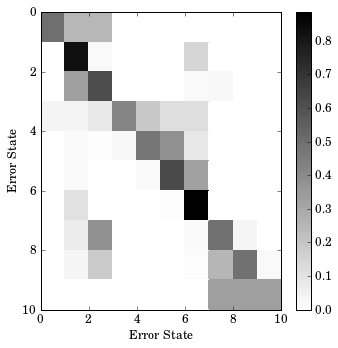

In [20]:
T_mat_11, b = tmatrix(df['Digital Pwr Error state 11'])
T_mat, b = tmatrix(df['Digital Pwr Error state 51'])
plot_T_mat(T_mat_11,save=False,name='J11_t_mat')

In [143]:
len(T_mat_11)

10

In [31]:
# Convention s = t,h,j
np.random.seed(0)
def stoch_simple_state(x,s):
    return (s[0]+1,s[1]-5+x,s[2])
   

def large_power_cost(x,s):
    global Tariff
    return x*Tariff[s[0],s[2]]
    
def val_T(s,settings):
    if s[1] < settings['Initial state'][1]:
        return float('inf') 
    else:
        return 0

Tariff = np.random.randint(0,20,size=(144,11))
    
pumping_stoch = StochasticProgram()
pumping_stoch.add_decisions_set({0,1,2,3,4,5,6,7,8,9,10})
#pumping_stoch.add_decisions_set({0,2,4,6,8,10})
pumping_stoch.add_cost_function(large_power_cost)
pumping_stoch.add_state_eq(stoch_simple_state)
pumping_stoch.add_final_value_expression(val_T)
pumping_stoch.add_state_limits(lower=[0,0],upper = [200,11])
pumping_stoch.set_inital_state([100,5])

pumping_stoch.add_transition_matrix(T_mat_11)
#pumping_stoch.add_transition_matrix(transition)

In [142]:
#pumping_stoch.settings

In [39]:
#%%timeit
pumping_stoch.set_step_number(5)
pumping_stoch.settings['cache'] ={}
pumping_stoch.solve()

90.546637176382717

In [40]:
# %%timeit
# pumping_stoch.set_step_number(144)
# pumping_stoch.settings['cache'] ={}
# pumping_stoch.solve()

In [41]:
#help(df)

In [42]:
pumping_stoch.print_pump_decisions()

KeyError: (1, 100, 0)

In [140]:
#pumping_stoch.return_cache()

In [60]:
import csv
def make_P_matrix(file_name='ProbabilityMatrix.csv'):
    """
    Returns a Pmatrix as np.array given by the csv
    file specified
    """
    Pmatrix = []
    with open(file_name, 'rb') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    
        for row in spamreader:
            Pmatrix.append([float(i) for i in row])
            
    return np.array(Pmatrix)

print(make_P_matrix('ProbabilityMatrix.csv'))

[[ 0.5   0.2   0.2   0.1   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.4   0.5   0.1   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.1   0.3   0.5   0.1   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.2   0.5   0.2   0.1   0.    0.    0.    0.    0.  ]
 [ 0.    0.1   0.    0.6   0.25  0.05  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.7   0.15  0.15  0.3   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.2   0.5   0.2   0.2   0.1   0.  ]
 [ 0.    0.    0.    0.    0.1   0.    0.4   0.5   0.1   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.3   0.1   0.3   0.5   0.1   0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.1   0.2   0.5   0.2 ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.1   0.    0.6   0.3 ]]


In [141]:
time = df['Data_analysis.ipynb']
wind = df['Forecasted power']

plt.plot(time[:24*6],wind[:24*6])
plt.show()

KeyError: 'Data_analysis.ipynb'

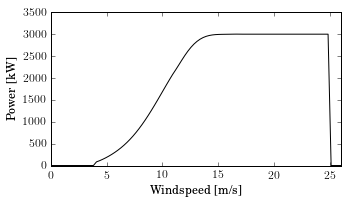

In [96]:
wind = []
pwr = []
for w in np.linspace(0,27,100):
    wind.append(w)
    pwr.append(Turb_power(w))

plt.figure(figsize=(5,3),tight_layout=True)
plt.plot(wind,pwr,'k')
plt.axis([0, 26, 0, 3500])
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
plt.xlabel('Windspeed [m/s]')
plt.ylabel('Power [kW]')
plt.savefig('D:\Phd\DP\Turbine_power_char.pdf',  format='pdf')
plt.show()

In [21]:
class system(object):
    """System"""
    def __init__(self):
        self.Turbines = {}

    def add_wind_turbine(self,TurbName = "V90/3MW",Cutin=4,Rated=15,Cutoff=25):
        self.Turbines[TurbName] = {'Cutin':Cutin,'Rated':Rated,'Cutoff':Cutoff}
        
    def calc_wind_power(self,Wind,TurbName):
        self.Power = self.Turb_power(Wind,Turbines[TurbName][Cutin],
                                     Turbines[TurbName][Rated],
                                     Turbines[TurbName][Cutoff],TurbName)
        
    

    def Turb_power(self,s,Cutin=4,Rated=15,Cutoff=25,TurbName = "V90/3MW"):
        """Describes the power output of a wind turbine as function of windspeed
        Cutin is the lower wind speed limit, Cutoff is the upper windspeed limit 
        and Limit is the point at which the power no longer increases as the 
        nominal power has been reached.

        Example Vestas V90
        Cut In:  4 m/s
        Rated:   15 m/s
        Cut Out: 25 m/s

        for partial range of V90/3MW we use to 6th order polynomial fitted to the curve
        """
        
        if TurbName == "V90/3MW":
            if s < Cutin:
                return 0
            elif s < 11:
                x = np.arange(4,12)
                y = np.array([75, 187, 348, 574, 875, 1257, 1688, 2118])
                p = np.polyfit(x, y, 6)
                return np.polyval(p,s)
            elif s < 17:
                x = np.arange(11,18)
                y = np.array([2118, 2514, 2817, 2958, 2994, 2999, 3000])
                p = np.polyfit(x, y, 6)
                return np.polyval(p,s)
            elif s < Cutoff:
                return 3000
            else:
                return 0
            
        else:
            factor = Turb_factor(Power,rating)
            if s < Cutin:
                return 0
            elif s < Rated:
                return (s**3)*factor
            elif s < Cutoff:
                return Rated**3*factor
            else:
                return 0

    def Turb_factor(self,Power,rating):
        """Given a Rated power and rating speed, computes the conversion factor"""
        return float(Power)/rating**3


The cost of operating a pump with a given wind turbine power input is given by:
$$
cost(x,t,h) := \begin{cases} T(t) \times (x \times P_p - W(t)) & \text{if} +ve \\ 
E_{xp} \times (x \times P_p - W(t)) & \text{if} -ve\end{cases}
$$
where $x$ is the descision variable, $W(t)$ is the wind turbine output in time step $t$. $P_p$ is the pump power, $E_{xp}$ is the export price.

In [4]:
def wind_power_cost(x,s):  
    """Very simple cost function for a pump with wind turbine power"""
    Tariff = [5,5,5,5,5,8,8,8,8,8,12,12,12,12,12,50,50,50,50,20,20,6,5,5]
    Wind = [46,  1,  3, 36, 30, 19,  9, 26, 35,  5, 49,  3,  6, 36, 43, 36, 14,
       34,  2,  0,  0, 30, 13, 36]
    
    Export_price = 5.5
        
    power_con = x*60-Wind[s[0]]
    if power_con >= 0:
        return power_con*Tariff[s[0]]
    else:
        return power_con*Export_price

    

In [27]:
def stoch_wind_power_cost(x,s):
    
    Tariff = [5,5,5,5,5,8,8,8,8,8,12,12,12,12,12,50,50,50,50,20,20,6,5,5]
    Wind = [46,  1,  3, 36, 30, 19,  9, 26, 35,  5, 49,  3,  6, 36, 43, 36, 14,
       34,  2,  0,  0, 30, 13, 36]
    
    Export_price = 5.5
    
    wind_out = sum(Wind[s[0]]*i for i in settings['P'][s[2]])
    
    power_con = x*60-wind_out
    if power_con >= 0:
        return power_con*Tariff[s[0]]
    else:
        return power_con*Export_price

$$
s_{new} = \begin{cases} (t+1,h-1,i) & \text{if } x = 0  \\ (t+1,h+1,i) & \text{if } x = 1 \\ (t+1,h+1.5,i) & \text{if } x = 2\end{cases}
$$

In [32]:
assert(hjb((settings['T'],settings['H_init']-1)) == 10000)
assert(hjb((settings['T'],settings['H_init'])) == 0)
assert(hjb((settings['T']-1,settings['H_min']-1)) == 10000)
assert(hjb((settings['T']-1,settings['H_max']+1)) == 10000)

state is given by $s = (t,h,i)$

$$
v(s) = \min_x(cost(x,s) + \sum_j p_{ij} v(new state(x,s)))
$$

In [34]:
def make_schedule(settings):
    sched = np.ones(settings['T'])*np.nan
    cost_calc= 0
    elev = np.ones(settings['T']+1)*np.nan

    s = settings['Initial state']
    t = 0
    
    while t < settings['T']:
        sched[t] = settings['cache'][s][1]
        print sched[t]

        cost_calc += settings['Cost eq.'](sched[t],s)
        elev[t] = s[1]

        s = settings['State eq.'](sched[t],s)
        t += 1

    elev[settings['T']] = s[1]
    
    return cost_calc, sched, elev

In [112]:
def make_schedule2(settings):
    
    sched_stack =  []
    cost_summary = []
    string_stack = []
    elev = np.ones(settings['T']+1)*np.nan
    for ij in [0,1,2]:
        cost_calc = 0
        string_stack.insert(i,[])
        s = settings['Initial state']
        t = 0
        #string_stack[ij].insert(0,[])
        #string_stack[ij].insert(0,'{0:2} {1} {2}'.format(t,settings['cache'][s][1], s[1:]))
        string_stack[ij].insert(0,'{0}'.format(s))
        while t < settings['T']:
            
            state = tuple(sk if sk in s[:-1] else ij for sk in s  )
            print s, s[:-1], state
            x = settings['cache'][state][1]
            print x
            cost_calc += settings['Cost eq.'](x,s)
            elev[t] = s[1]

            s = settings['State eq.'](x,s)
            t += 1
            string_stack[ij].insert(t,'{0} {1} {2}'.format(x,s[1:],ij) )


    elev[settings['T']] = s[1]
    
    return string_stack, cost_calc

In [113]:
make_schedule2(settings)

(0, 100, 0) (0, 100) (0, 100, 0)
0
(1, 99, 0) (1, 99) (1, 99, 0)
1
(2, 100, 0) (2, 100) (2, 100, 0)
1
(0, 100, 0) (0, 100) (0, 100, 0)
0
(1, 99, 0) (1, 99) (1, 99, 1)
1
(2, 100, 0) (2, 100) (2, 100, 1)
1
(0, 100, 0) (0, 100) (0, 100, 0)
0
(1, 99, 0) (1, 99) (1, 99, 2)
1
(2, 100, 0) (2, 100) (2, 100, 2)
1


([['(0, 100, 0)', '0 (99, 0) 0', '1 (100, 0) 0', '1 (101, 0) 0'],
  ['(0, 100, 0)', '0 (99, 0) 1', '1 (100, 0) 1', '1 (101, 0) 1'],
  ['(0, 100, 0)', '0 (99, 0) 2', '1 (100, 0) 2', '1 (101, 0) 2']],
 363.5)

In [74]:
settings['cache']

{(0, 100, 80): [35, 1],
 (1, 99, 79): [36, 2],
 (1, 100, 81.5): [8, 1],
 (1, 101, 80): [16, 2],
 (2, 98, 78): [10000, 0],
 (2, 99, 80.5): [20, 1],
 (2, 100, 79): [40, 2],
 (2, 100, 83.0): [20, 1],
 (2, 101, 81.5): [0, 0],
 (2, 102, 80): [20, 1]}

In [49]:
def stoch_hjb(s):
    global settings
    if settings['cache'].has_key(s):
        return settings['cache'][s][0]
    

  
    
    if s[0] == settings['T'] and s[1] < settings['H_init']:
        return 10000
    
    elif s[0] == settings['T'] and s[1] >= settings['H_init']:
        return 0
    
    elif s[1] < settings['H_min'] or s[1] > settings['H_max']:
        return 10000
    
    else:
        p=[]
        for x in settings['x_set']:
            future = sum(stoch_hjb(settings['State eq.'](x,(s[0],s[1],i)))
                          *settings['P'][s[2]][i] for i in [0,1,2])
            
            p.append(settings['Cost eq.'](x,s) + future)
                    
        
        m = min(p)
        
        for x in settings['x_set']:
            if m == p[x]:
                pp = x
                
        settings['cache'][s] = [m, pp]
        
        return m

In [75]:
A = []
for i in [0,1,2]:
    A.insert(i,[])
    print A
    for t in range(5):
        A[i].insert(t,i*t**2)

        
A

[[]]
[[0, 0, 0, 0, 0], []]
[[0, 0, 0, 0, 0], [0, 1, 4, 9, 16], []]


[[0, 0, 0, 0, 0], [0, 1, 4, 9, 16], [0, 2, 8, 18, 32]]

In [66]:
cost_calc, sched, elev = make_schedule(settings)
print sched
print elev
print cost_calc

1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
[ 1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  1.  1.]
[ 100.  101.  102.  103.  104.  105.  106.  105.  106.  107.  106.  107.
  106.  105.  104.  103.  102.  101.  100.   99.   98.   97.   98.   99.
  100.]
1353.0


In [55]:
settings['cache'][settings['Initial state']]

[28, 0]

In [20]:
cost_calc, sched, elev = make_schedule(settings)
print sched
print elev
print cost_calc

[ 1.  1.  0.]
[ 100.  101.  102.  101.]
27.0


In [39]:
dic = {'blub': simple_cost
      }
dic['blub']

<function __main__.simple_cost>

In [40]:
dic['blub'](1,(0,1))

19

In [11]:
len([5,5,5,5,5,8,8,8,8,8,12,12,12,12,12,50,50,50,50,20,20,6,5,5])

24

In [12]:
np.random.randint(50,size=24)

array([46,  1,  3, 36, 30, 19,  9, 26, 35,  5, 49,  3,  6, 36, 43, 36, 14,
       34,  2,  0,  0, 30, 13, 36])

In [47]:
x = [100,7,90,787]
x_lim_min = [0,10,0,0]
x_lim_max = [100,10,100,1000]
for c,i in enumerate(x):
    if i < x_lim_min[c] or i > x_lim_max[c]:
        print 1000
    

1000
